# Binary Classification Deep Learning Model for BNP Paribas Cardif Claims Management Using TensorFlow Take 1
### David Lowe
### August 17, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The BNP Paribas Cardif Claims Management dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: As a global specialist in personal insurance, BNP Paribas Cardif sponsored a Kaggle competition to help them identify the categories of claims. In a world shaped by the emergence of new practices and behaviors generated by the digital economy, BNP Paribas Cardif would like to streamline its claims management practice. In this Kaggle challenge, the company challenged the participants to predict the category of a claim based on features available early in the process. Better predictions can help BNP Paribas Cardif accelerate its claims process and therefore provide a better service to its customers.

In the previous Scikit-Learn iterations, we constructed and tuned machine learning models for this dataset using the Scikit-Learn and the XGBoost libraries. We also observed the best accuracy result that we could obtain using the tuned models with the training, validation, and test datasets.

In this Take1 iteration, we will construct and tune machine learning models for this dataset using TensorFlow with three layers. We will observe the best accuracy result that we can obtain using the tuned models with the validation and test datasets. Furthermore, we will apply the MLP model to Kaggle's test dataset and submitted a list of predictions to Kaggle for evaluation.

ANALYSIS: From the previous Scikit-Learn iterations, the optimized XGBoost model processed the testing dataset with a log loss metric of 0.4634.

From this Take1 iteration, the performance of the three-layer TensorFlow model achieved a log loss score of 0.4720 with the training dataset. After a series of tuning trials, the TensorFlow model processed the validation dataset with a log loss score of 0.4726, which was consistent with the prediction from the training result. When configured with the optimized parameters, the TensorFlow model processed the test dataset with a log loss score of 0.4736, which was consistent with the training/tuning phase.

CONCLUSION: For this dataset, the model built using TensorFlow with three layers achieved a satisfactory result. We should consider using TensorFlow to model this dataset further.

Dataset Used: BNP Paribas Cardif Claims Management Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/overview

One potential source of performance benchmark: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 2.9MB/s 


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Aug 11 20:08:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Direct Colab to use TensorFlow v2
%tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the number of folds for cross validation
n_folds = 5

# Set the percentage sizes for splitting the dataset
# test_set_size = 0.2
val_set_size = 0.25

# Set various default Keras modeling parameters
default_loss = keras.losses.BinaryCrossentropy()
default_metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.he_uniform(seed=seedNum)
default_epoch = 20
default_batch = 32

# Define the labels to use for graphing the data
train_metric = "loss"
validation_metric = "val_loss"
train_loss = "loss"
validation_loss = "val_loss"

Num GPUs Available:  1


In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [12]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-bnp-paribas-cardif-claims-management/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', index_col=False)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,4.012088,7.711453,7.653429,12.707581,2.015505,10.498338,9.848672,0.113561,C,12.171733,8.086643,0.899420,7.277792,G,16.747968,0.037096,1.299638,DI,3.971118,0.529802,10.890984,1.588448,15.858152,1,0.153461,6.363189,18.303925,C,9.314079,15.231789,17.142857,11.784549,F,1,1.614988,B,D,2.230940,7.292418,8.571429,E,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,0.095678,0.905342,A,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,NaN,14.305766,NaN,NaN,NaN,NaN,NaN,2.449959,E,NaN,NaN,1.379210,NaN,G,NaN,1.129469,NaN,DY,NaN,NaN,NaN,NaN,NaN,2,2.544736,NaN,NaN,A,NaN,NaN,NaN,12.053353,F,2,NaN,B,D,NaN,NaN,NaN,D,NaN,7.277655,3.430691,NaN,NaN,NaN,NaN,9.848004,NaN,2.678584,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,7.378964,13.077201,6.173469,12.346939,2.926830,8.897561,5.343819,0.126035,C,12.711328,6.836734,0.604504,9.637627,F,15.102041,0.085573,0.765305,AS,4.030613,4.277456,9.105481,2.151361,16.075602,1,0.123643,5.517949,16.377205,A,8.367347,11.040463,5.882353,8.460654,B,3,2.413618,B,B,1.963971,5.918368,11.764705,E,3.333334,10.194433,8.266200,1.530611,1.530613,2.429906,1.071429,8.447465,3.367346,0.111388,0.811447,G,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,0.287322,11.523045,7.931035,12.935823,1.470878,12.708574,9.670823,0.108387,C,12.194855,8.591954,3.329176,4.780357,H,16.621695,0.139721,1.178161,BW,3.965517,1.732102,11.777912,1.229246,15.927390,1,0.140260,6.292979,17.011645,A,9.703065,18.568129,9.425288,13.594728,F,2,2.272541,B,D,2.188198,8.213602,13.448277,B,1.947261,4.797873,13.315819,1.681034,1.379310,1.587045,1.242817,10.

In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Data columns (total 133 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      int64  
 1   target  int64  
 2   v1      float64
 3   v2      float64
 4   v3      object 
 5   v4      float64
 6   v5      float64
 7   v6      float64
 8   v7      float64
 9   v8      float64
 10  v9      float64
 11  v10     float64
 12  v11     float64
 13  v12     float64
 14  v13     float64
 15  v14     float64
 16  v15     float64
 17  v16     float64
 18  v17     float64
 19  v18     float64
 20  v19     float64
 21  v20     float64
 22  v21     float64
 23  v22     object 
 24  v23     float64
 25  v24     object 
 26  v25     float64
 27  v26     float64
 28  v27     float64
 29  v28     float64
 30  v29     float64
 31  v30     object 
 32  v31     object 
 33  v32     float64
 34  v33     float64
 35  v34     float64
 36  v35     float64
 37  v36     float64
 38  v37     float64
 39  v38     int64  
 40  v

In [15]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

v1      49832
v2      49796
v3       3457
v4      49796
v5      48624
v6      49832
v7      49832
v8      48619
v9      49851
v10        84
v11     49836
v12        86
v13     49832
v14         4
v15     49836
v16     49895
v17     49796
v18     49832
v19     49843
v20     49840
v21       611
v22       500
v23     50675
v25     48619
v26     49832
v27     49832
v28     49832
v29     49832
v30     60110
v31      3457
v32     49832
v33     49832
v34       111
v35     49832
v36     48624
v37     49843
v39     49836
v40       111
v41     49832
v42     49832
v43     49836
v44     49796
v45     49832
v46     48619
v48     49796
v49     49832
v50        86
v51     50678
v52         3
v53     49836
v54     48619
v55     49832
v56      6882
v57     49832
v58     49836
v59     49796
v60     49832
v61     49796
v63     48619
v64     49796
v65     49840
v67     49832
v68     49836
v69     49895
v70     48636
v73     49836
v76     49796
v77     49832
v78     49895
v80     49851
v81     48624
v82   

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  5097471


## 2.b) Splitting Data into Training/Validation Sets

In [17]:
# Drop the ID or index column not used for modeling
Xy_original.drop(columns=['ID'], inplace=True)

# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [18]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (114321, 132) X_original.shape: (114321, 131) y_original.shape: (114321,)


In [19]:
# Split the data further into smaller datasets
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_original, y_original, test_size=val_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))

X_train_df.shape: (85740, 131) y_train_df.shape: (85740,)
X_validation_df.shape: (28581, 131) y_validation_df.shape: (28581,)


## 2.c) Data Visualization

In [20]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

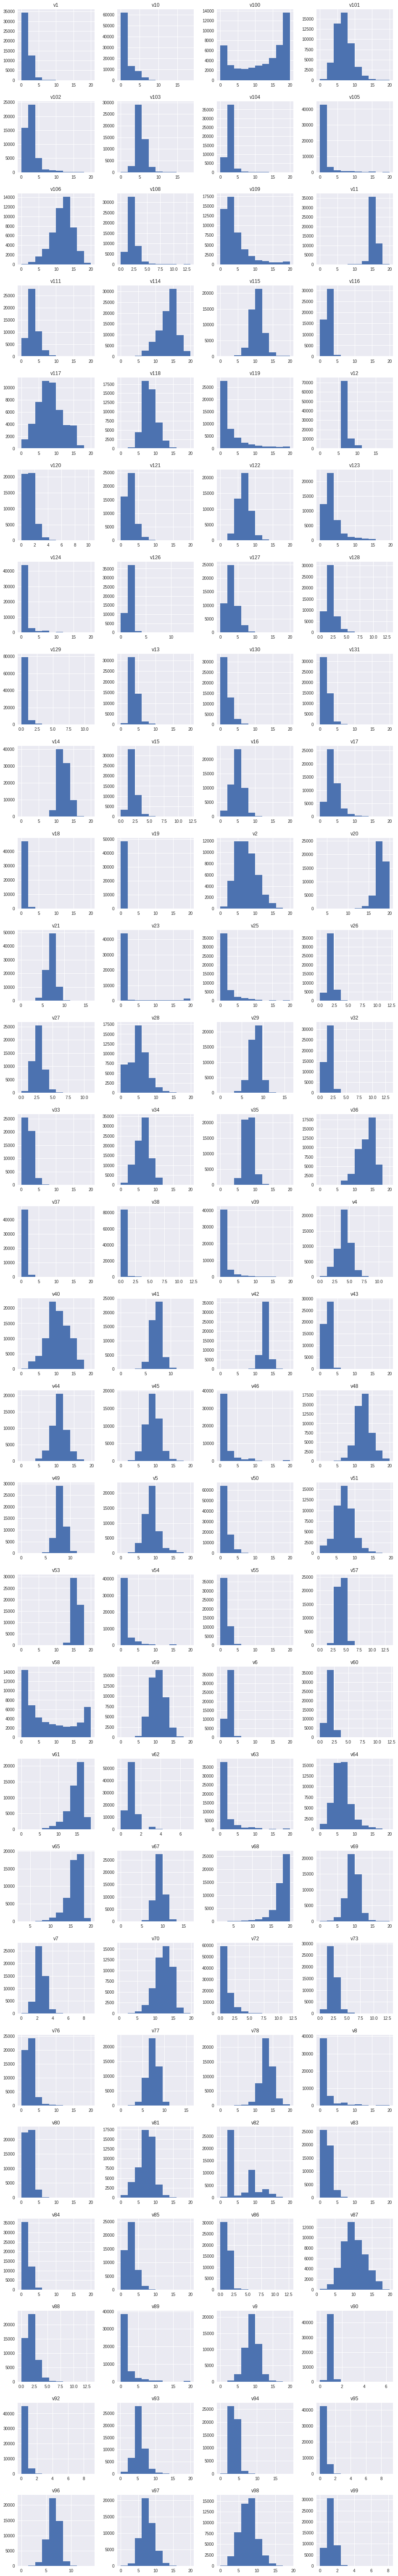

In [21]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

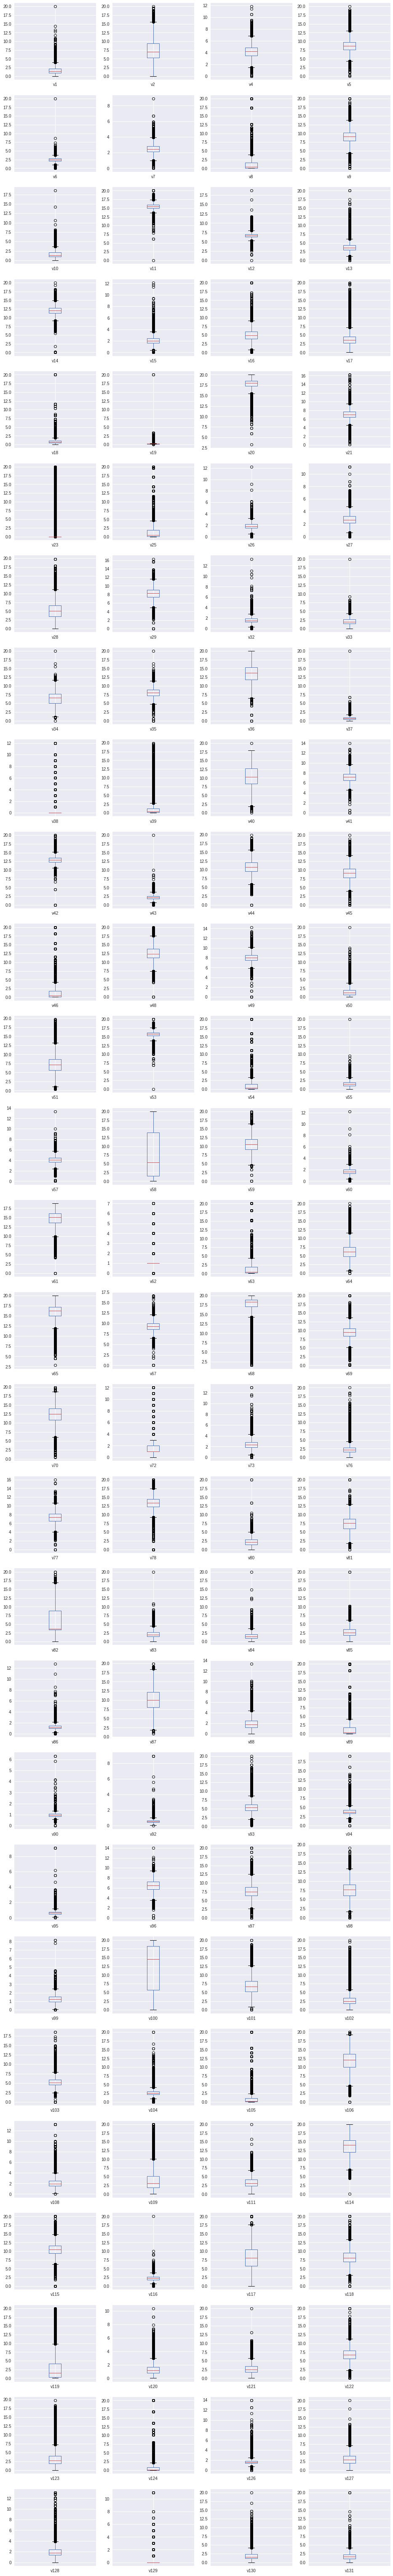

In [22]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

## 2.d) Prepare and Clean Data

In [23]:
# Dropping columns with very low or no predictive power
X_train_df.drop(columns=['v22'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', PowerTransformer())
])

categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 112
Number of categorical columns: 18
Total number of columns in the dataframe: 130


In [25]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training datasets for final inspection
X_train = preprocessor.fit_transform(X_train_df)
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (85740, 483) y_train.shape: (85740,)


In [26]:
# Apply the same data preparation steps to the validation dataset
# Dropping columns with very low or no predictive power
X_validation_df.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_validation = preprocessor.transform(X_validation_df)
y_validation = y_validation_df.ravel()
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


X_validation.shape: (28581, 483) y_validation.shape: (28581,)


In [27]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [28]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
# Define the baseline model for benchmarking
def create_nn_model(input_nodes=0, layer1_nodes=32, layer2_nodes=16, layer3_nodes=8, layer4_nodes=0, layer5_nodes=0, 
                    layer1_dropout=0, layer2_dropout=0, layer3_dropout=0, layer4_dropout=0, layer5_dropout=0, 
                    opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential()
    nn_model.add(keras.layers.Dense(layer1_nodes, input_shape=(input_nodes,), activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer1_dropout))
    nn_model.add(keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer2_dropout))
    nn_model.add(keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param))
    nn_model.add(keras.layers.BatchNormalization())
    nn_model.add(keras.layers.Dropout(layer3_dropout))
    # nn_model.add(keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param))
    # nn_model.add(keras.layers.BatchNormalization())
    # nn_model.add(keras.layers.Dropout(layer4_dropout))
    # nn_model.add(keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param))
    # nn_model.add(keras.layers.BatchNormalization())
    # nn_model.add(keras.layers.Dropout(layer5_dropout))
    nn_model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init_param))
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [30]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(24, 12))
    metrics =  ['loss', 'auc', 'precision', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # if metric == 'loss':
        #     plt.ylim([0, plt.ylim()[1]])
        # elif metric == 'auc':
        #     plt.ylim([0.8,1])
        # else:
        #     plt.ylim([0,1])
        plt.legend()

In [31]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_nn_model(input_nodes=X_train.shape[1])
baseline_history = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/20
2680/2680 [==============================] - 21s 8ms/step - loss: 0.5073 - tp: 61544.0000 - fp: 16804.0000 - tn: 3671.0000 - fn: 3721.0000 - accuracy: 0.7606 - precision: 0.7855 - recall: 0.9430 - auc: 0.7003 - val_loss: 0.4846 - val_tp: 20569.0000 - val_fp: 5264.0000 - val_tn: 1561.0000 - val_fn: 1187.0000 - val_accuracy: 0.7743 - val_precision: 0.7962 - val_recall: 0.9454 - val_auc: 0.7343
Epoch 2/20
2680/2680 [==============================] - 20s 7ms/step - loss: 0.4870 - tp: 62807.0000 - fp: 16966.0000 - tn: 3509.0000 - fn: 2458.0000 - accuracy: 0.7735 - precision: 0.7873 - recall: 0.9623 - auc: 0.7283 - val_loss: 0.4915 - val_tp: 20591.0000 - val_fp: 5452.0000 - val_tn: 1373.0000 - val_fn: 1165.0000 - val_accuracy: 0.7685 - val_precision: 0.7907 - val_recall: 0.9465 - val_auc: 0.7232
Epoch 3/20
2680/2680 [==============================] - 20s 7ms/step - loss: 0.4833 - tp: 62732.0000 - fp: 16819.0000 - tn: 3656.0000 - fn: 2533.0000 - accuracy: 0.7743 - precision: 0.7886

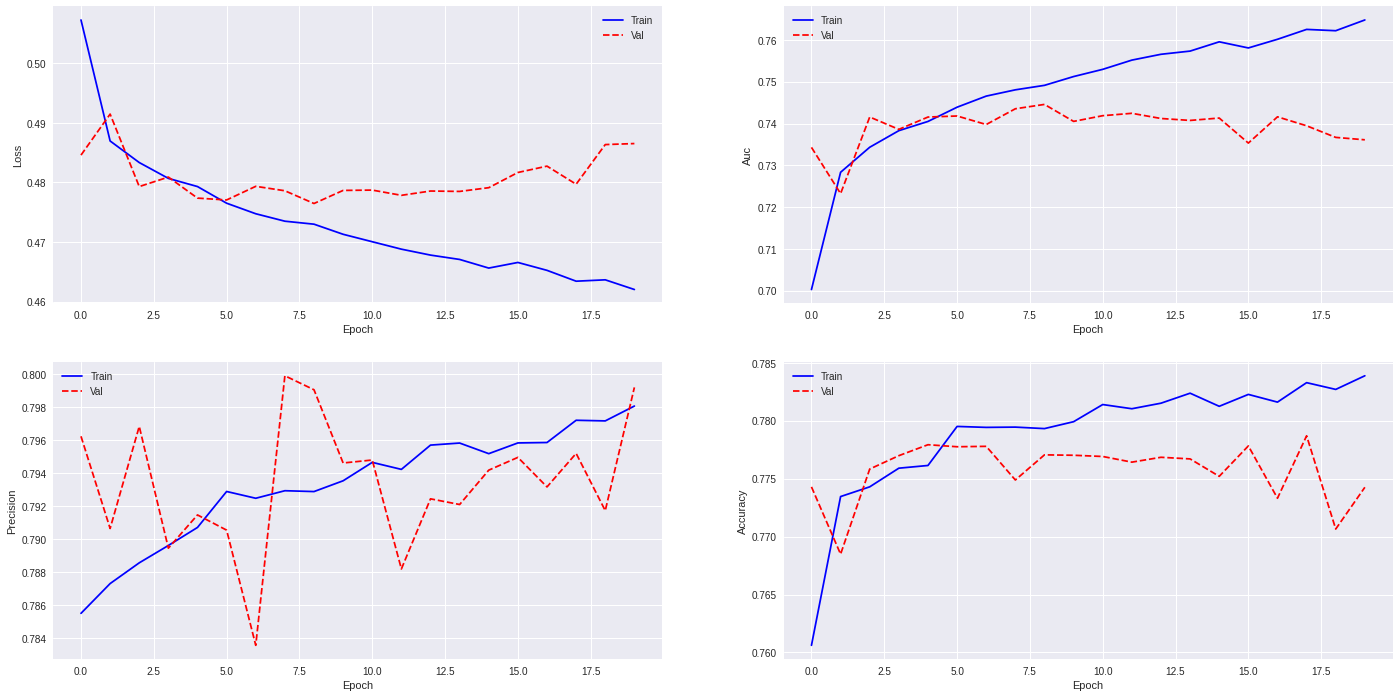

In [32]:
plot_metrics(baseline_history)

In [33]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [34]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Initialize the grid parameters and fit the models
nodes_grid = [(64, 32, 16, 0, 0), (96, 48, 24, 0, 0), (128, 64, 32, 0, 0), (256, 128, 64, 0, 0), (512, 256, 128, 0, 0)]
layer5_dropout, layer4_dropout, layer3_dropout, layer2_dropout, layer1_dropout = (0, 0, 0, 0, 0)

# Build dataframe for reporting model performance summary
nodes_performance = pd.DataFrame(columns=['model_name', 'train_score', 'validation_score', 'variance', 'layer1_nodes', 'layer2_nodes', 'layer3_nodes', 'layer4_nodes',
                                          'layer5_nodes', 'layer1_dropout', 'layer2_dropout', 'layer3_dropout', 'layer4_dropout', 'layer5_dropout'])

serial_number = 0
for param in nodes_grid:
    startTimeModule = datetime.now()
    serial_number = serial_number + 1
    model_name = "Model_" + str(serial_number).zfill(3)
    layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes = param
    reset_random(seedNum)
    grid_search_model = create_nn_model(X_train.shape[1], layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, 
                                        layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout, default_optimizer, default_kernel_init)
    print('Processing model %s with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes' %
          (model_name, layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes))
    model_train_hist = grid_search_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=1)
    train_score = model_train_hist.history[train_metric][-1]
    validation_score = model_train_hist.history[validation_metric][-1]
    train_val_variance = abs(train_score - validation_score)
    print('The minimum score for the training dataset: %.4f' % (min(model_train_hist.history[train_metric])))
    print('The score at the last epoch for the training dataset: %.4f' % (train_score))
    print('The minimum score for the validation dataset: %.4f' % (min(model_train_hist.history[validation_metric])))
    print('The score at the last epoch for the validation dataset: %.4f' % (validation_score))
    print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
    print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
    nodes_performance = nodes_performance.append({'model_name': model_name, 'train_score': train_score, 'validation_score': validation_score, 'variance': train_val_variance, 
                                                  'layer1_nodes': layer1_nodes, 'layer2_nodes': layer2_nodes, 'layer3_nodes': layer3_nodes, 'layer4_nodes': layer4_nodes,
                                                  'layer5_nodes': layer5_nodes, 'layer1_dropout': layer1_dropout, 'layer2_dropout': layer2_dropout, 'layer3_dropout': layer3_dropout,
                                                  'layer4_dropout': layer4_dropout, 'layer5_dropout': layer5_dropout}, ignore_index=True)

nodes_performance.set_index('model_name', inplace=True)

Processing model Model_001 with Layer 1: 64, Layer 2: 32, Layer 3: 16, Layer 4: 0, and Layer 5: 0 nodes
Epoch 1/20
2680/2680 [==============================] - 21s 8ms/step - loss: 0.4951 - tp: 83385.0000 - fp: 22722.0000 - tn: 4578.0000 - fn: 3636.0000 - accuracy: 0.7694 - precision: 0.7859 - recall: 0.9582 - auc: 0.7206 - val_loss: 0.4833 - val_tp: 20956.0000 - val_fp: 5639.0000 - val_tn: 1186.0000 - val_fn: 800.0000 - val_accuracy: 0.7747 - val_precision: 0.7880 - val_recall: 0.9632 - val_auc: 0.7366
Epoch 2/20
2680/2680 [==============================] - 20s 8ms/step - loss: 0.4871 - tp: 62907.0000 - fp: 17097.0000 - tn: 3378.0000 - fn: 2358.0000 - accuracy: 0.7731 - precision: 0.7863 - recall: 0.9639 - auc: 0.7287 - val_loss: 0.4831 - val_tp: 20505.0000 - val_fp: 5195.0000 - val_tn: 1630.0000 - val_fn: 1251.0000 - val_accuracy: 0.7745 - val_precision: 0.7979 - val_recall: 0.9425 - val_auc: 0.7370
Epoch 3/20
2680/2680 [==============================] - 20s 8ms/step - loss: 0.4851 -

In [36]:
# Display the model performance summary by validation score
nodes_performance.sort_values(by=['validation_score'], ascending=True).head()

,train_score,validation_score,variance,layer1_nodes,layer2_nodes,layer3_nodes,layer4_nodes,layer5_nodes,layer1_dropout,layer2_dropout,layer3_dropout,layer4_dropout,layer5_dropout
model_name,,,,,,,,,,,,,
Model_004,0.455284,0.482745,0.027460,256,128,64,0,0,0,0,0,0,0
Model_003,0.455744,0.484554,0.028811,128,64,32,0,0,0,0,0,0,0
Model_005,0.455991,0.486046,0.030055,512,256,128,0,0,0,0,0,0,0
Model_002,0.455772,0.486265,0.030493,96,48,24,0,0,0,0,0,0,0
Model_001,0.458418,0.486291,0.027873,64,32,16,0,0,0,0,0,0,0


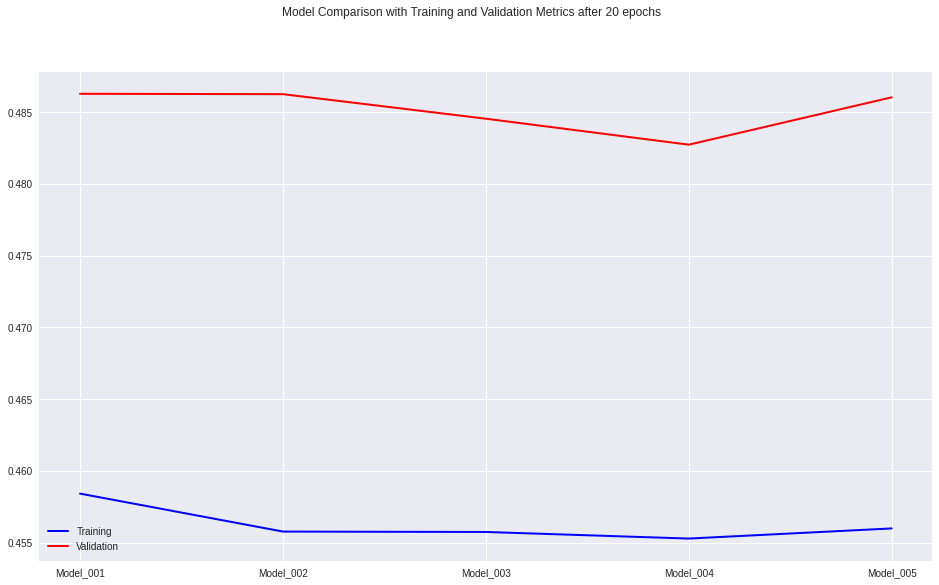

In [37]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Training and Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(nodes_performance['train_score'], color='b', lw=2.)
ax1.plot(nodes_performance['validation_score'], color='r', lw=2.)
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

In [38]:
# Initialize the grid parameters for the dropout ratio
startTimeModule = datetime.now()
model_to_use = 'Model_004'
layer1_nodes = nodes_performance.loc[model_to_use]['layer1_nodes']
layer2_nodes = nodes_performance.loc[model_to_use]['layer2_nodes']
layer3_nodes = nodes_performance.loc[model_to_use]['layer3_nodes']
layer4_nodes = nodes_performance.loc[model_to_use]['layer4_nodes']
layer5_nodes = nodes_performance.loc[model_to_use]['layer5_nodes']
layer1_dropout_grid = [0.2, 0.35, 0.5]
layer2_dropout_grid = [0.2, 0.35, 0.5]
layer3_dropout_grid = [0.5]
layer4_dropout_grid = [0]
layer5_dropout_grid = [0]

# Build dataframe for reporting model performance summary
dropout_performance = pd.DataFrame(columns=['model_name','train_score','validation_score','variance','layer1_nodes','layer2_nodes','layer3_nodes','layer4_nodes',
                                            'layer5_nodes','layer1_dropout','layer2_dropout','layer3_dropout','layer4_dropout','layer5_dropout'])

serial_number = 0
for layer1_dropout in layer1_dropout_grid:
    for layer2_dropout in layer2_dropout_grid:
        for layer3_dropout in layer3_dropout_grid:
            for layer4_dropout in layer4_dropout_grid:
                for layer5_dropout in layer5_dropout_grid:
                    startTimeIteration = datetime.now()
                    serial_number = serial_number + 1
                    model_name = "Model_" + str(serial_number).zfill(3)
                    reset_random(seedNum)
                    grid_search_model = create_nn_model(X_train.shape[1], layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, 
                                                        layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout, default_optimizer, default_kernel_init)
                    print('Processing model %s with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes and dropout parameters of Layer 1: %.2f, Layer 2: %.2f, Layer 3: %.2f, Layer 4: %.2f, and Layer 5: %.2f' %
                        (model_name, layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout))
                    model_train_hist = grid_search_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_validation, y_validation), verbose=0)
                    train_score = model_train_hist.history[train_metric][-1]
                    validation_score = model_train_hist.history[validation_metric][-1]
                    train_val_variance = abs(train_score - validation_score)
                    print('The minimum score for the training dataset: %.4f' % (min(model_train_hist.history[train_metric])))
                    print('The score at the last epoch for the training dataset: %.4f' % (train_score))
                    print('The minimum score for the validation dataset: %.4f' % (min(model_train_hist.history[validation_metric])))
                    print('The score at the last epoch for the validation dataset: %.4f' % (validation_score))
                    print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
                    print('Total time for model fitting:', (datetime.now() - startTimeIteration), '\n')
                    dropout_performance = dropout_performance.append({'model_name': model_name, 'train_score': train_score, 'validation_score': validation_score, 'variance': train_val_variance,
                                                                    'layer1_nodes': layer1_nodes, 'layer2_nodes': layer2_nodes, 'layer3_nodes': layer3_nodes, 'layer4_nodes': layer4_nodes,
                                                                    'layer5_nodes': layer5_nodes, 'layer1_dropout': layer1_dropout, 'layer2_dropout': layer2_dropout, 'layer3_dropout': layer3_dropout,
                                                                    'layer4_dropout': layer4_dropout, 'layer5_dropout': layer5_dropout}, ignore_index=True)

dropout_performance.set_index('model_name', inplace=True)
print('Total time for performing grid-search of the best dropout parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 256, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.20, Layer 2: 0.20, Layer 3: 0.50, Layer 4: 0.00, and Layer 5: 0.00
The minimum score for the training dataset: 0.4653
The score at the last epoch for the training dataset: 0.4653
The minimum score for the validation dataset: 0.4735
The score at the last epoch for the validation dataset: 0.4758
The training vs. validation variance at the last epoch is: 0.0105
Total time for model fitting: 0:05:22.171633 

Processing model Model_002 with Layer 1: 256, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.20, Layer 2: 0.35, Layer 3: 0.50, Layer 4: 0.00, and Layer 5: 0.00
The minimum score for the training dataset: 0.4684
The score at the last epoch for the training dataset: 0.4684
The minimum score for the validation dataset: 0.4746
The score at the last epoch for the validation dataset: 0.4756
The trainin

In [39]:
# Display the model performance summary by validation score
dropout_performance.sort_values(by=['validation_score'], ascending=True).head()

,train_score,validation_score,variance,layer1_nodes,layer2_nodes,layer3_nodes,layer4_nodes,layer5_nodes,layer1_dropout,layer2_dropout,layer3_dropout,layer4_dropout,layer5_dropout
model_name,,,,,,,,,,,,,
Model_006,0.472619,0.473172,0.000553,256,128,64,0,0,0.35,0.50,0.5,0,0
Model_005,0.472155,0.473333,0.001178,256,128,64,0,0,0.35,0.35,0.5,0,0
Model_007,0.474057,0.473833,0.000224,256,128,64,0,0,0.50,0.20,0.5,0,0
Model_008,0.474321,0.475258,0.000937,256,128,64,0,0,0.50,0.35,0.5,0,0
Model_002,0.468392,0.475648,0.007256,256,128,64,0,0,0.20,0.35,0.5,0,0


In [40]:
# Display the model performance summary by variance
dropout_performance.sort_values(by=['variance']).head()

,train_score,validation_score,variance,layer1_nodes,layer2_nodes,layer3_nodes,layer4_nodes,layer5_nodes,layer1_dropout,layer2_dropout,layer3_dropout,layer4_dropout,layer5_dropout
model_name,,,,,,,,,,,,,
Model_007,0.474057,0.473833,0.000224,256,128,64,0,0,0.50,0.20,0.5,0,0
Model_009,0.475648,0.476121,0.000473,256,128,64,0,0,0.50,0.50,0.5,0,0
Model_006,0.472619,0.473172,0.000553,256,128,64,0,0,0.35,0.50,0.5,0,0
Model_008,0.474321,0.475258,0.000937,256,128,64,0,0,0.50,0.35,0.5,0,0
Model_005,0.472155,0.473333,0.001178,256,128,64,0,0,0.35,0.35,0.5,0,0


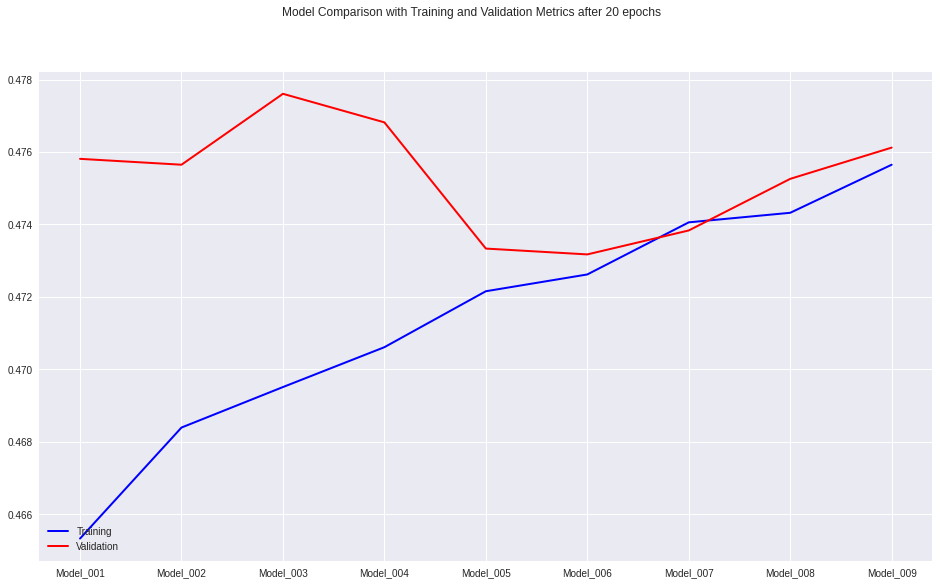

In [41]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Training and Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(dropout_performance['train_score'], color='b', lw=2.)
ax1.plot(dropout_performance['validation_score'], color='r', lw=2.)
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

In [43]:
# Initialize the grid parameters for the optimizer, kernel, and batch size
startTimeModule = datetime.now()
model_to_use = 'Model_006'
layer1_nodes = dropout_performance.loc[model_to_use]['layer1_nodes']
layer2_nodes = dropout_performance.loc[model_to_use]['layer2_nodes']
layer3_nodes = dropout_performance.loc[model_to_use]['layer3_nodes']
layer4_nodes = dropout_performance.loc[model_to_use]['layer4_nodes']
layer5_nodes = dropout_performance.loc[model_to_use]['layer5_nodes']
layer1_dropout = dropout_performance.loc[model_to_use]['layer1_dropout']
layer2_dropout = dropout_performance.loc[model_to_use]['layer2_dropout']
layer3_dropout = dropout_performance.loc[model_to_use]['layer3_dropout']
layer4_dropout = dropout_performance.loc[model_to_use]['layer4_dropout']
layer5_dropout = dropout_performance.loc[model_to_use]['layer5_dropout']

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

batch_grid = [default_batch]

grid_iteration = 1
best_score = 1
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
epoch_num = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for batch_num in batch_grid:
            startTimeIteration = datetime.now()
            print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d' % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
            reset_random(seedNum)
            grid_model = create_nn_model(X_train.shape[1], layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout, optimizer, kernel_init)
            grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data=(X_validation, y_validation), verbose=0)
            train_score = grid_hist.history[train_metric][-1]
            validation_score = grid_hist.history[validation_metric][-1]
            train_val_variance = abs(train_score - validation_score)
            print('The minimum score for the training dataset: %.4f' % (min(grid_hist.history[train_metric])))
            print('The score at the last epoch for the training dataset: %.4f' % (train_score))
            print('The minimum score for the validation dataset: %.4f' % (min(grid_hist.history[validation_metric])))
            print('The score at the last epoch for the validation dataset: %.4f' % (validation_score))
            print('The training vs. validation variance at the last epoch is: %.4f' % (train_val_variance))
            print('Total time for model fitting:', (datetime.now() - startTimeIteration), '\n')
            if(validation_score < best_score):
                best_score = validation_score
                best_iteration = grid_iteration
                best_optimizer = optimizer
                best_kernel_init = kernel_init
                best_epoch = epoch_num
                best_batch = batch_num
            grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (from validation) found via grid search: %f from model iteration #%d"
      % (best_score, best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa05a4f12b0>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fa05a4f1a20>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fa05a4f1f60>
Initializer candidate #1 has the object ID of <tensorflow.python.keras.initializers.initializers_v2.HeUniform object at 0x7fa058127ef0>
Initializer candidate #2 has the object ID of <tensorflow.python.keras.initializers.initializers_v2.Orthogonal object at 0x7fa058127080>
Initializer candidate #3 has the object ID of <tensorflow.python.keras.initializers.initializers_v2.RandomUniform object at 0x7fa05a4f1400>

Forming the grid-search model #1 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa05a4f12b0>, kernel=<tensorflow.python.keras.initializers.initializers_v2.HeUniform object at 0x7fa0581

In [44]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [45]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 5.a) Create a standalone model using all available data

In [46]:
# Apply the same data preparation steps to the original training dataset

# Dropping columns with very low or no predictive power
X_original.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_complete = preprocessor.fit_transform(X_original)
y_complete = y_original.ravel()
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

X_complete.shape: (114321, 486) y_complete.shape: (114321,)


In [47]:
# Create the final model for evaluating the test dataset
final_optimizer = best_optimizer
final_kernel_init = best_kernel_init
final_epoch = best_epoch
final_batch = best_batch
print('Processing final model with Layer 1: %d, Layer 2: %d, Layer 3: %d, Layer 4: %d, and Layer 5: %d nodes and dropout parameters of Layer 1: %.2f, Layer 2: %.2f, Layer 3: %.2f, Layer 4: %.2f, and Layer 5: %.2f' 
      % (layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout))
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d' % (final_optimizer, final_kernel_init, final_epoch, final_batch))

Processing final model with Layer 1: 256, Layer 2: 128, Layer 3: 64, Layer 4: 0, and Layer 5: 0 nodes and dropout parameters of Layer 1: 0.35, Layer 2: 0.50, Layer 3: 0.50, Layer 4: 0.00, and Layer 5: 0.00
Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa05a4f12b0>, kernel=<tensorflow.python.keras.initializers.initializers_v2.RandomUniform object at 0x7fa05a4f1400>, epochs=20, batch_size=32


In [48]:
reset_random(seedNum)
final_model = create_nn_model(X_complete.shape[1], layer1_nodes, layer2_nodes, layer3_nodes, layer4_nodes, layer5_nodes, layer1_dropout, layer2_dropout, layer3_dropout, layer4_dropout, layer5_dropout, final_optimizer, final_kernel_init)
final_model.fit(X_complete, y_complete, epochs=final_epoch, batch_size=final_batch, verbose=1)

Epoch 1/20
3573/3573 [==============================] - 23s 6ms/step - loss: 0.5034 - tp: 104609.0000 - fp: 29250.0000 - tn: 4875.0000 - fn: 4168.0000 - accuracy: 0.7661 - precision: 0.7815 - recall: 0.9617 - auc: 0.7105
Epoch 2/20
3573/3573 [==============================] - 23s 7ms/step - loss: 0.4901 - tp: 83913.0000 - fp: 23199.0000 - tn: 4101.0000 - fn: 3108.0000 - accuracy: 0.7699 - precision: 0.7834 - recall: 0.9643 - auc: 0.7254
Epoch 3/20
3573/3573 [==============================] - 23s 6ms/step - loss: 0.4877 - tp: 83883.0000 - fp: 22968.0000 - tn: 4332.0000 - fn: 3138.0000 - accuracy: 0.7716 - precision: 0.7850 - recall: 0.9639 - auc: 0.7289
Epoch 4/20
3573/3573 [==============================] - 23s 6ms/step - loss: 0.4855 - tp: 83785.0000 - fp: 22813.0000 - tn: 4487.0000 - fn: 3236.0000 - accuracy: 0.7721 - precision: 0.7860 - recall: 0.9628 - auc: 0.7330
Epoch 5/20
3573/3573 [==============================] - 23s 6ms/step - loss: 0.4839 - tp: 83718.0000 - fp: 22549.0000 -

In [49]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 256)               124672    
_________________________________________________________________
batch_normalization_72 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_73 (Batc (None, 128)               512       
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 64)              

## 5.c) Create Submission Files for Kaggle Evaluation

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-bnp-paribas-cardif-claims-management/test.csv'
X_kaggle_data = pd.read_csv(dataset_path, sep=',', index_col=False)

# Take a peek at the dataframe after import
X_kaggle_data.head(10)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.375465e+00,11.361141,C,4.200778,6.577000,2.081784,1.784386,0.011094,9.523810,1.312911,16.851853,6.961173,3.107462,12.230137,1.773050,2.857142,3.493816,0.096826,0.225481,17.910227,7.437806,AFPB,9.558310e-07,E,0.069180,0.954152,4.386616,0.573017,6.988848,NaN,A,1.115242,2.081784,5.228503,8.178438,12.183225,8.333339e-01,0,2.842768e+00,11.754576,6.765800,10.855019,1.296297,10.613377,9.417172,0.100480,J,12.774528,7.509293,0.118847,8.590755,C,17.021277,0.044313,1.338291,AF,2.602230,2.919712e-01,9.038609,0.817843,14.911512,1,0.091466,5.967949,15.611474,A,8.029739,15.912409,8.571429,11.222210,F,1,1.929013,B,D,2.146860,6.171004,15.714287,Q,1.904761,8.918731,8.750729,2.453532,0.892192,1.860465,0.892193,7.904968,1.784387,0.105298,0.988980,B,0.658269,4.929298,2.992365,0.759955,5.947955,4.999999,10.013503,0.817844,19.708030,4.186787,1.873945,4.129022,1.701894,0.004535,11.688117,B,1.502480,2.121710,A,3.568773,U,NaN,12.246698,11.428572,1.276596,4.777902,5.833334,-9.974950e-07,1.459854,3.267328,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.291029,NaN,6.618289,NaN,10.760796,NaN,NaN,NaN,NaN,NaN,NaN,5.895192,FOG,NaN,D,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,8.387431,NaN,NaN,NaN,4,NaN,6.737574,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,1.027070,NaN,A,NaN,NaN,NaN,DI,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,F,5,NaN,B,D,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,B,NaN,E,NaN,16.284938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,2,-4.903407e-07,8.201529,C,4.544371,6.550100,1.558442,2.467532,0.007164,7.142858,1.575492,15.142858,6.894249,1.899789,13.306189,1.302083,3.333334,3.177414,0.070676,0.172391,17.537549,8.253452,HXZ,-2.137218e-07,B,0.059620,2.857142,2.207792,0.327134,8.311689,C,A,0.974026,1.558442,7.958990,8.311689,12.195123,-5.249334e-07,0,6.707352e+00,7.701325,6.883118,12.077923,3.428570,10.215687,7.908401,0.082194,I,12.770831,7.792207,0.840731,9.885153,A,15.000000,0.020126,0.779222,DO,5.454544,-8.476044e-07,9.452010,2.857142,15.561143,1,0.083718,5.633655,15.778656,C,9.090908,13.200000,6.666666,7.860585,F,1,1.488096,B,D,1.910292,5.714285,16.666667,C,1.428572,8.952301,8.744891,1.948051,0.779221,1.860465,0.779221,5.886226,5.714285,0.043851,0.918734,C,0.552642,4.350983,3.163664,0.604966,6.233767,12.631578,10.214574,0.952380,19.799999,6.535555,0.762963,4.917534,1.981859,0.002794,11.747048,D,1.188768,2.088817,A,3.116883,Q,AJ,15.622710,13.333334,3.750001,4.740574,12.631580,4.910660e-08,0.600000,2.500001,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
3,7,2.661870e+00,3.041241,C,1.657216,9.773080,2.078337,1.430855,1.252157,7.959596,1.575493,14.424357,6.856236,5.086604,10.397026,2.803497,7.302904,1.121984,0.608524,0.476554,15.285588,5.539484,AGMU,5.863396e-07,E,1.779993,1.406875,1.350919,5.347444,6.474820,E,A,2.362111,3.852918,6.223849,6.634692,13.741929,2.011174e+00,0,8.248888e-07,10.444974,6.059153,13.189448,1.826832,7.635934,12.850679,1.504218,I,16.791675,7.801759,0.946373,8.578365,A,15.382717,1.351259,3.812951,CN,4.356514,1.953542e+01,10.425885,1.128431,10.935236,1,1.809689,2.181748,12.366115,B,8.401279,17.677120,13.195021,14.124303,F,1,3.905010,B,D,0.644581,6.370902,11.203320,C,3.555555,6.284919,3.264427,3.237409,4.220623,6.000001,1.306954,13.037068,0.431654,2.035947,1.495102,B,0.775499

In [51]:
# Set up the dataframe to capture predictions for Kaggle submission
y_submission_kaggle = pd.DataFrame(columns=['ID', 'PredictedProb'])
y_submission_kaggle['ID'] = X_kaggle_data['ID']
X_kaggle_data.drop(columns=['ID'], inplace=True)
y_submission_kaggle.head()

,ID,PredictedProb
0,0,NaN
1,1,NaN
2,2,NaN
3,7,NaN
4,10,NaN


In [52]:
# Apply the same data preparation steps to the test dataset

# Dropping columns with very low or no predictive power
X_kaggle_data.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_test_kaggle = preprocessor.transform(X_kaggle_data)
print("X_test_kaggle.shape: {}".format(X_test_kaggle.shape))

X_test_kaggle.shape: (114393, 486)


In [53]:
probabilities_kaggle = final_model.predict(X_test_kaggle)
y_submission_kaggle['PredictedProb'] = probabilities_kaggle
print("y_submission_kaggle.shape: {}".format(y_submission_kaggle.shape))

y_submission_kaggle.shape: (114393, 2)


In [54]:
submission_file = y_submission_kaggle.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20200811-2258.csv


In [55]:
if (notifyStatus): status_notify("Phase 5 Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 2:50:20.519750
